# Summarizing Privacy Policy - Data Wrangling

## Contents

* [Introduction](#Introduction)
* [Objectives](#Objectives)
* [About the dataset](#About-the-dataset)
* [Import Tools](#Import-Tools)
* [Recreating the Dataframe](#Recreating-the-Dataframe)
* [Common Words](#Common-Words)
* [Splitting the Data](#Splitting-the-Data)
* [Hugging Face Transformer](#Hugging-Face-Transformer)
* [Evaluating Hugging Face with Rouge](#Evaluating-Hugging-Face-with-Rouge)
* [Evaluating Hugging Face with BLEU](#Evaluating-Hugging-Face-with-BLEU)
* [Evaluating Hugging Face with BERTScore](#Evaluating-Hugging-Face-with-BERTScore)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction<a id='Introduction'></a>

In this notebook, I will import and preprocess privacy policy data, preparing it for modeling with natural language 
processing techniques. The preprocessing pipeline will ensure the data is cleaned, structured, and optimized for analysis. 
I plan to experiment with multiple modeling approaches to identify the most effective and computationally efficient method. 
To evaluate performance, I will implement a suite of metrics to ensure the selected model achieves optimal results, 
balancing accuracy and efficiency. This systematic approach aims to maximize the success and reliability of the final model.

## Objectives<a id='Objectives'></a>

*[Contents](#Contents)

In this project I am going to create an algorithm to summarize text, in particular the terms of service privacy policy. 
There are several methods this can be accomplished and results tested for, I plan to use a few.

## About the dataset<a id='About-the-dataset'></a>

*[Contents](#Contents)

421 pairs of (agreement text, summary) from data privacy policies

From https://aclanthology.org/W19-2201/
Abstract
Unilateral legal contracts, such as terms of service, play a substantial role in modern digital life. However, few read these documents before accepting the terms within, as they are too long and the language too complicated. We propose the task of summarizing such legal documents in plain English, which would enable users to have a better understanding of the terms they are accepting. We propose an initial dataset of legal text snippets paired with summaries written in plain English. We verify the quality of these summaries manually, and show that they involve heavy abstraction, compression, and simplification. Initial experiments show that unsupervised extractive summarization methods do not perform well on this task due to the level of abstraction and style differences. We conclude with a call for resource and technique development for simplification and style transfer for legal language.

The project was based on the articles and datasets.

https://github.com/maastrichtlawtech/awesome-legal-nlp

https://aclanthology.org/W19-2201/

https://github.com/lauramanor/legal_summarization/tree/master

## Import Tools<a id='Import-Tools'></a>

*[Contents](#Contents)

In [1]:
import json
import pandas as pd
import os
from dotenv import load_dotenv

## Recreating the Dataframe<a id='Recreating-the-Dataframe'></a>

*[Contents](#Contents)

In [2]:
# Load environment variables from the .env file
load_dotenv()

# Get file path from environment variable
file_path = os.getenv("FILE_PATH")

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract relevant data into a dataframe
records = []
for item in data.values():
    records.append({
        'legal_text': item.get('original_text', ''),
        'summary': item.get('reference_summary', '')
    })

# Convert to DataFrame
df = pd.DataFrame(records)

# Inspect the DataFrame
print(df.head())

                                          legal_text  \
0  search encrypt does not track search history i...   
1  we also provide you additional data control op...   
2  rvices you grant oath the following worldwide ...   
3  we may change these terms and conditions to re...   
4  it also enables us to serve you advertising an...   

                                             summary  
0                   this service does not track you.  
1  you can request access and deletion of persona...  
2  the copyright license granted to yahoo for pho...  
3  if you are a subscriber jagex will treat the f...  
4  the service uses your personal data to employ ...  


## Common Words<a id='Common-Words'></a>

*[Contents](#Contents)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\where\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\where\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


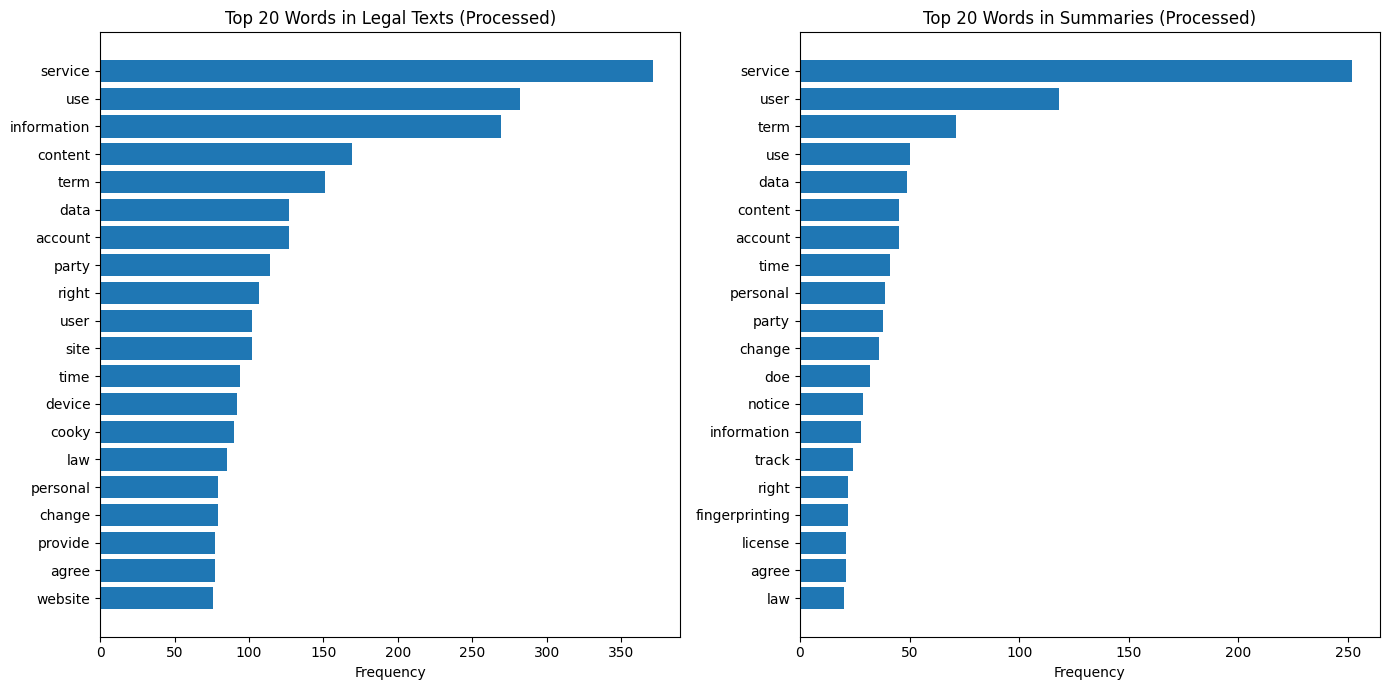

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.stem import WordNetLemmatizer
from nltk import download

# Download NLTK resources if not already installed
download('wordnet')
download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    # Lowercase, remove punctuation, and split into words
    words = re.sub(r'[^\w\s]', '', text.lower()).split()
    # Remove stop words and lemmatize
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in ENGLISH_STOP_WORDS]
    return cleaned_words

# Combine and preprocess legal texts and summaries
legal_text_words = preprocess_text(' '.join(df['legal_text'].tolist()))
summary_words = preprocess_text(' '.join(df['summary'].tolist()))

# Count word frequencies
legal_text_counter = Counter(legal_text_words)
summary_counter = Counter(summary_words)

# Get the top 20 most common words
top_legal_words = legal_text_counter.most_common(20)
top_summary_words = summary_counter.most_common(20)

# Extract words and their counts for plotting
legal_words, legal_counts = zip(*top_legal_words)
summary_words, summary_counts = zip(*top_summary_words)

# Plot top 20 words in legal texts
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(legal_words, legal_counts)
plt.xlabel('Frequency')
plt.title('Top 20 Words in Legal Texts (Processed)')
plt.gca().invert_yaxis()

# Plot top 20 words in summaries
plt.subplot(1, 2, 2)
plt.barh(summary_words, summary_counts)
plt.xlabel('Frequency')
plt.title('Top 20 Words in Summaries (Processed)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Splitting the Data<a id='Splitting-the-Data'></a>

*[Contents](#Contents)

In [4]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1


In [5]:
from sklearn.model_selection import train_test_split
from transformers import pipeline
import pandas as pd

In [6]:
# Split the data into training and testing sets
train_texts, test_texts, train_summaries, test_summaries = train_test_split(
    df['legal_text'], df['summary'], test_size=0.2, random_state=42
)

# Create training and testing DataFrames
train_df = pd.DataFrame({'legal_text': train_texts, 'summary': train_summaries})
test_df = pd.DataFrame({'legal_text': test_texts, 'summary': test_summaries})

## Hugging Face Transformer<a id='Hugging-Face-Transformer'></a>

*[Contents](#Contents)

In [7]:
# Load the pre-trained summarization model and specify GPU (device=0)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)

In [8]:
def summarize_with_dynamic_lengths(texts, batch_size=8):
    def compute_lengths(text):
        input_length = len(text.split())
        max_length = max(10, int(input_length * 0.75))  # At least 10 tokens, or 75% of input length
        min_length = max(5, int(input_length * 0.25))  # At least 5 tokens, or 25% of input length
        return max_length, min_length

    summaries = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Create a batch of texts
        
        # Dynamically calculate lengths for the batch
        lengths = [compute_lengths(text) for text in batch]
        max_lengths = [l[0] for l in lengths]
        min_lengths = [l[1] for l in lengths]
        
        # Apply summarizer to the batch, truncating if necessary
        batch_summaries = []
        for text, max_len, min_len in zip(batch, max_lengths, min_lengths):
            summary = summarizer(text, max_length=max_len, min_length=min_len, truncation=True)
            batch_summaries.append(summary[0]['summary_text'])
        
        summaries.extend(batch_summaries)

    return summaries

# Apply the summarization function
test_df['generated_summary'] = summarize_with_dynamic_lengths(test_df['legal_text'].tolist(), batch_size=8)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Evaluating Hugging Face with Rouge<a id='Evaluating-Hugging-Face-with-Rouge'></a>

*[Contents](#Contents)

In [9]:
import evaluate

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Calculate ROUGE scores
scores = rouge.compute(
    predictions=test_df['generated_summary'].tolist(),
    references=test_df['summary'].tolist()
)

# Display scores
print("ROUGE Scores:", scores)

ROUGE Scores: {'rouge1': np.float64(0.21884259155689426), 'rouge2': np.float64(0.07015122818672762), 'rougeL': np.float64(0.18037303715848363), 'rougeLsum': np.float64(0.17987318540871808)}


## Evaluating Hugging Face with BLEU<a id='Evaluating-Hugging-Face-with-BLEU'></a>

*[Contents](#Contents)

In [10]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Initialize NLTK smoothing function for BLEU
smoothing_function = SmoothingFunction().method1

# Predictions and references from your DataFrame
predictions = test_df['generated_summary'].tolist()
references = test_df['summary'].tolist()

# Calculate BLEU scores
bleu_scores = []

for pred, ref in zip(predictions, references):
    # Tokenize the reference and prediction
    ref_tokens = [ref.split()]  # Reference should be a list of tokenized sentences
    pred_tokens = pred.split()  # Prediction is a single tokenized sentence

    # Calculate BLEU score for the current pair
    score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothing_function)
    bleu_scores.append(score)

# Average BLEU score across all pairs
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu * 100:.2f}%")

Average BLEU Score: 3.30%


## Evaluating Hugging Face with BERTScore<a id='Evaluating-Hugging-Face-with-BERTScore'></a>

*[Contents](#Contents)

In [11]:
from bert_score import score

# Prepare the generated summaries (predictions) and reference summaries
predictions = test_df['generated_summary'].tolist()
references = test_df['summary'].tolist()

# Calculate BERTScore
P, R, F1 = score(predictions, references, lang="en", verbose=True)

# Average the scores across all examples
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1 Score: {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.38 seconds, 189.65 sentences/sec
Precision: 0.8408
Recall: 0.8739
F1 Score: 0.8567


## Conclusion<a id='Conclusion'></a>

*[Contents](#Contents)

The Hugging Face model seemed to perform well under certain metrics. It seems as though ROUGE and BLEU are designed to measure using the same words 
by comparison. With BERTScore, it uses the hidden states (embeddings) of tokens produced by a transformer model to represent both the generated and 
reference texts. These embeddings capture the context and meaning of each token, enabling the metric to assess similarity beyond exact word matches. 
It also does token matching which, for each token in the generated summary, BERTScore finds the most similar token in the reference summary (and 
vice versa) using cosine similarity. Why does semantic similarity matter? BERTScore accounts for lexical variation in word choice and syntax that 
maintain the same meaning, which metrics like BLEU and ROUGE may penalize. Words are interpreted within their contextual awareness, making 
BERTScore robust to synonyms and paraphrasing.

## References<a id='References'></a>

*[Contents](#Contents)

https://github.com/maastrichtlawtech/awesome-legal-nlp

https://aclanthology.org/W19-2201/

https://github.com/lauramanor/legal_summarization/tree/master